# Rule-Based Model in Omega

This notebook explores the application of Omega and Gillespie sampling to a Rule-based model of Kinase phosphorylation: https://github.com/djinnome/kappa-counterfactuals.

### Load Packages and SBML

In [10]:
# Noisy code here
using StatsBase
using Random
using Plots
using Distributions
using PyCall
using DataStructures


The model is represented in an SBML. Julia does not have a dedicated package to load an SBML so the python package tellurium is used.

In [11]:
te = pyimport("tellurium")
sbml = te.loadSBMLModel("../SBML/Kappa_resimulationmodel_sbml_KaDE.sbml")
ant = te.sbmlToAntimony("../SBML/Kappa_resimulationmodel_sbml_KaDE.sbml")
print(ant)

In [13]:
function get_parameters(sbml_file_path)
        
    """
    Function to extract model parameters from sbml. Returns dictionary with 
    a transition matrix, species list, and rates list.
    """
    ## Load SBML
    sbml = te.loadSBMLModel(sbml_file_path)

    ## Transition Matrix
    transition = sbml.getFullStoichiometryMatrix()
    transition = transpose(transition)
    
    ## Extract Species
    species_ids = sbml.getFloatingSpeciesIds()
    species_starting_vals = sbml.getFloatingSpeciesAmounts()
    species = Dict(species_ids .=> species_starting_vals)
    
    ## Extract Rates
    rates = Dict(sbml.getGlobalParameterIds() .=> sbml.getGlobalParameterValues())
    
    return Dict("transition" => transition, "species" => species, "rates" => rates)
    
end

get_parameters (generic function with 1 method)

In [22]:
model_params = get_parameters("../SBML/Kappa_resimulationmodel_sbml_KaDE.sbml")
t = vcat(model_params["transition"], [0 0 0 0 0 0 0 0])
species = model_params["species"]
rates = model_params["rates"]
print()

### Build Model

In [23]:
function reaction_gen(rng, n, theta)
    
    """
    Function representing the categorical sampling of rules. Converted into random
    variable using Omega's 'ciid' function
    
    parameters
    ----
    rng: seed for randomnization
    n: previous step of simulation
    theta: rate parameters
    """
    
    ecology = OrderedDict("s1" => S1_vals[n], "s2" => S2_vals[n], "s3" => S3_vals[n], 
        "s4" => S4_vals[n], "s5" => S5_vals[n], "s6" => S6_vals[n], "s7" => S7_vals[n], 
        "s8" => S8_vals[n])
    
    haz = OrderedDict(sbml.getReactionIds() .=> [
        ecology["s3"]*theta["mod_rate_slow"],
        ecology["s3"]*theta["off_rate_fast"],
        ecology["s3"]*theta["mod_rate"],
        ecology["s8"]*theta["mod_rate_slow"],
        ecology["s8"]*theta["off_rate_fast"],
        (1/theta["VA"])*(ecology["s7"]*ecology["s1"]),
        (1/theta["VA"])*(ecology["s7"]*ecology["s4"]),
        ecology["s6"]*theta["off_rate_slow"],
        ecology["s5"]*theta["off_rate_slow"],
        ecology["s5"]*theta["mod_rate"],
        (1/theta["VA"])*(ecology["s2"]*ecology["s4"]),
        ecology["s1"]*theta["mod_rate_slow"],
        (1/theta["VA"])*(ecology["s2"]*ecology["s1"])]
        )
    
    for (key, val) in haz
        if val < 0
            haz[key] = 0 - value
        end
    end
    
    ## Get values from hazard dictionary
    vals = collect(values(haz))
    sum_vals = sum(vals)
    ## Calculate probabilities
    prob_vals = vals/sum_vals
    ## Sample
    hazard_result = categorical(rng, prob_vals)

    return hazard_result
end

function time_gen(rng, n, theta)
    
    """
    Function representing the exponential sampling of time. Converted into random
    variable using Omega's 'ciid' function
    
    parameters
    ----
    rng: seed for randomnization
    n: previous step of simulation
    theta: rate parameters
    """
    
    ecology = OrderedDict("s1" => S1_vals[n], "s2" => S2_vals[n], "s3" => S3_vals[n], 
        "s4" => S4_vals[n], "s5" => S5_vals[n], "s6" => S6_vals[n], "s7" => S7_vals[n], 
        "s8" => S8_vals[n])
    
    haz = OrderedDict(sbml.getReactionIds() .=> [
        ecology["s3"]*theta["mod_rate_slow"],
        ecology["s3"]*theta["off_rate_fast"],
        ecology["s3"]*theta["mod_rate"],
        ecology["s8"]*theta["mod_rate_slow"],
        ecology["s8"]*theta["off_rate_fast"],
        (1/theta["VA"])*(ecology["s7"]*ecology["s1"]),
        (1/theta["VA"])*(ecology["s7"]*ecology["s4"]),
        ecology["s6"]*theta["off_rate_slow"],
        ecology["s5"]*theta["off_rate_slow"],
        ecology["s5"]*theta["mod_rate"],
        (1/theta["VA"])*(ecology["s2"]*ecology["s4"]),
        ecology["s1"]*theta["mod_rate_slow"],
        (1/theta["VA"])*(ecology["s2"]*ecology["s1"])]
        )
    
    haz_sum = sum([abs(x) for x in values(haz)])
    update = exponential(rng, haz_sum)
    time_val = time_list[n](rng) + update
    
    return time_val
end

function deterministic_updater(rng, n, transition, theta)

    """
    Function representing deterministic update to Gillespie.
    
    parameters
    ----
    rng: seed for randomnization
    n: previous step of simulation
    transition: transition matrix for deterministic update of model
    theta: rate parameters
    """
    
    ecology = OrderedDict("s1" => S1_vals[n], "s2" => S2_vals[n], "s3" => S3_vals[n], 
        "s4" => S4_vals[n], "s5" => S5_vals[n], "s6" => S6_vals[n], "s7" => S7_vals[n], 
        "s8" => S8_vals[n])
    
    haz = OrderedDict(sbml.getReactionIds() .=> [
        ecology["s3"]*theta["mod_rate_slow"],
        ecology["s3"]*theta["off_rate_fast"],
        ecology["s3"]*theta["mod_rate"],
        ecology["s8"]*theta["mod_rate_slow"],
        ecology["s8"]*theta["off_rate_fast"],
        (1/theta["VA"])*(ecology["s7"]*ecology["s1"]),
        (1/theta["VA"])*(ecology["s7"]*ecology["s4"]),
        ecology["s6"]*theta["off_rate_slow"],
        ecology["s5"]*theta["off_rate_slow"],
        ecology["s5"]*theta["mod_rate"],
        (1/theta["VA"])*(ecology["s2"]*ecology["s4"]),
        ecology["s1"]*theta["mod_rate_slow"],
        (1/theta["VA"])*(ecology["s2"]*ecology["s1"])]
        )
    

    reaction = reaction_list[n](rng)

    update_val = deepcopy(transition[reaction, :])
    id = collect(keys(haz))[reaction]
    
    if haz[id] < 0
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    insert!(S1_vals, n + 1, ecology["s1"] + update_val[1])
    insert!(S2_vals, n + 1, ecology["s2"] + update_val[2])
    insert!(S3_vals, n + 1, ecology["s3"] + update_val[3])
    insert!(S4_vals, n + 1, ecology["s4"] + update_val[4])
    insert!(S5_vals, n + 1, ecology["s5"] + update_val[5])
    insert!(S6_vals, n + 1, ecology["s6"] + update_val[6])
    insert!(S7_vals, n + 1, ecology["s7"] + update_val[7])
    insert!(S8_vals, n + 1, ecology["s8"] + update_val[8])
    
    return reaction
end

deterministic_updater (generic function with 1 method)

### Unconditioned Model

In [24]:
## Initialize lists to hold random variables and species values
global time_list = Any[]; global reaction_list = Any[]; global update_list = Any[]

global S1_vals = []; global S2_vals = []; global S3_vals = []
global S4_vals = []; global S5_vals = []; global S6_vals = []
global S7_vals = []; global S8_vals = []

## Insert starting species values
push!(S1_vals, species["s1"])
push!(S2_vals, species["s2"])
push!(S3_vals, species["s3"])
push!(S4_vals, species["s4"])
push!(S5_vals, species["s5"])
push!(S6_vals, species["s6"])
push!(S7_vals, species["s7"])
push!(S8_vals, species["s8"])
insert!(time_list, 1, uniform([0]))

## Create random variables for each step
for f in 2:10 # 10 steps of gillespie
    last = f - 1
    push!(reaction_list, ciid(reaction_gen, last, rates))
    push!(time_list, ciid(time_gen, last, rates))
    push!(update_list, ciid(deterministic_updater, last, t, rates))
end

rv = (Tuple(update_list)..., Tuple(time_list)...)
print()

In [25]:
## Sample
Random.seed!(15)
samples = rand(rv, 1, alg = RejectionSample)
print()

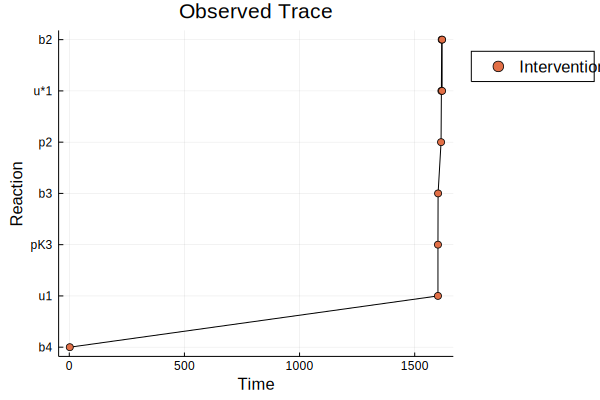

In [26]:
map_dict = OrderedDict(1 => "pK1", 2 => "u1", 3 => "p1", 4 => "pK2",
    5 => "u2", 6 => "b1", 7 => "b2", 8 => "u*1", 9 => "u*2", 
    10 => "p2", 11 => "b3", 12 => "pK3", 13 => "b4", 14 => "NoReaction")
simple_labels = [map_dict[i] for i in samples[1][1:9]]

plot([x for x in samples[1][11:19]], simple_labels,
        linecolor = ["black"], label = false)
plot!([x for x in samples[1][11:19]], simple_labels,
        title = "Observed Trace",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Intervention" "No Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

### Conditioned Model

In [27]:
## Initialize lists to hold random variables and species values
global time_list = Any[]; global reaction_list = Any[]; global update_list = Any[]

global S1_vals = []; global S2_vals = []; global S3_vals = []
global S4_vals = []; global S5_vals = []; global S6_vals = []
global S7_vals = []; global S8_vals = []

## Condition vals
condition = [[x for x in samples[1][1:9]], [x for x in samples[1][11:19]]]

## Insert starting species values
push!(S1_vals, species["s1"])
push!(S2_vals, species["s2"])
push!(S3_vals, species["s3"])
push!(S4_vals, species["s4"])
push!(S5_vals, species["s5"])
push!(S6_vals, species["s6"])
push!(S7_vals, species["s7"])
push!(S8_vals, species["s8"])
insert!(time_list, 1, uniform([0]))

## Create random variables for each step
for f in 2:10
    
    last = f - 1
    temp_rv = ciid(reaction_gen, last, rates)
    ## Condition on original sim
    temp_rv = cond(temp_rv, temp_rv ==ₛ condition[1][last])
    push!(reaction_list, temp_rv)
    
    temp_time = ciid(time_gen, last, rates)
    ## Condition on original sim
    temp_time = cond(temp_time, temp_time ==ₛ condition[2][last])
    push!(time_list, temp_time)

    push!(update_list, ciid(deterministic_updater, last, t, rates))
end

condition_rv = (Tuple(update_list)..., Tuple(time_list)...)
print()

In [ ]:
cond_samples = rand(condition_rv, 10000, alg = Replica)
print()

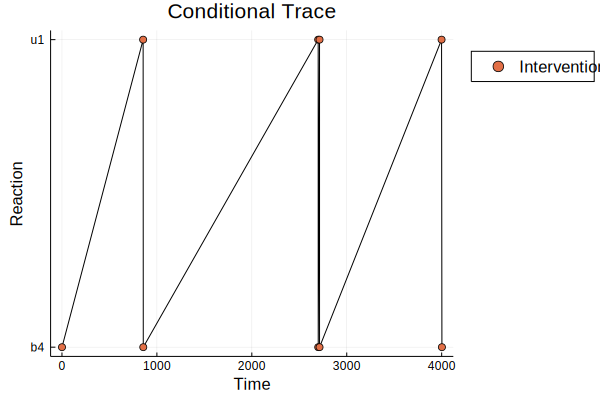

In [14]:
cond_labels = [map_dict[i] for i in cond_samples[1][1:9]]

plot([x for x in cond_samples[1][11:19]], cond_labels,
        linecolor = ["black"], label = false)
plot!([x for x in cond_samples[1][11:19]], cond_labels,
        title = "Conditional Trace",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Intervention" "No Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

### Counterfactual Model

To build the counterfactual model we can use the conditional model but add an intervention.

In [ ]:
reaction_list[3] = replace(reaction_list[3], reaction_list[3] => 13)

In [ ]:
counterfactual_samples = rand(condition_rv, 10000, alg = Replica)

In [ ]:
counterfactual_labels = [map_dict[i] for i in counterfactual_samples[1][1:9]]

plot([x for x in counterfactual_samples[1][11:19]], counterfactual_labels,
        linecolor = ["black"], label = false)
plot!([x for x in counterfactual_samples[1][11:19]], counterfactual_labels,
        title = "Conditional Trace",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Intervention" "No Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)